# Running Injury Clinic data

Reginaldo K Fukuchi, Feb 2023, reginaldo.fukuchi@ufabc.edu.br

This NB imports mat file containing joint angle data and save as txt files

In [1]:
# Prepare environment
import os, glob
import scipy.io as spio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
# Import data
dir_path = r'C:\Users\Reginaldo\Documents\data\CNPq\MCR_run'
fnames = glob.glob(os.path.join(dir_path,'*.mat'))
fname = fnames[0]
fname

'C:\\Users\\Reginaldo\\Documents\\data\\CNPq\\MCR_run\\20130731T140334.mat'

## Import mat file data
### Helper functions to prepare data
https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

### Import mat file data

In [7]:
# Import data
data = loadmat(fname)

In [8]:
data['out'].keys()

dict_keys(['full_static', 'speed_w', 'full_walk', 'speed_r', 'full_run', 'rawneutral', 'neutral', 'joints', 'walking', 'running', 'hz_r', 'hz_w', 'dv_w', 'dv_r', 'flexdata', 'strengthdata', 'aligndata', 'demo', 'IDnumber', 'location', 'Inj', 'datestring', 'w_angles', 'w_velocities', 'w_norm_ang', 'w_norm_vel', 'w_events', 'r_angles', 'r_velocities', 'r_norm_ang', 'r_norm_vel', 'r_events'])

In [26]:
joints = list(data['out']['r_norm_ang'].keys())
joints = ['hip','knee','ankle']
axes = ['X','Y','Z']

In [23]:
events = data['out']['r_events']
max_stride_time_R = np.max(np.diff(events, axis=0)[:,2])

In [11]:
rknee = np.array(data['out']['r_angles']['R_knee'])

## PENDING
* TIME NORMALIZE DATA
* AVERAGE ACROSS TRIALS
* SAVE AS TXT
* PICK SIMILAR SUBJECTS IN RBDS
* COMPARE THEM

<IPython.core.display.Javascript object>


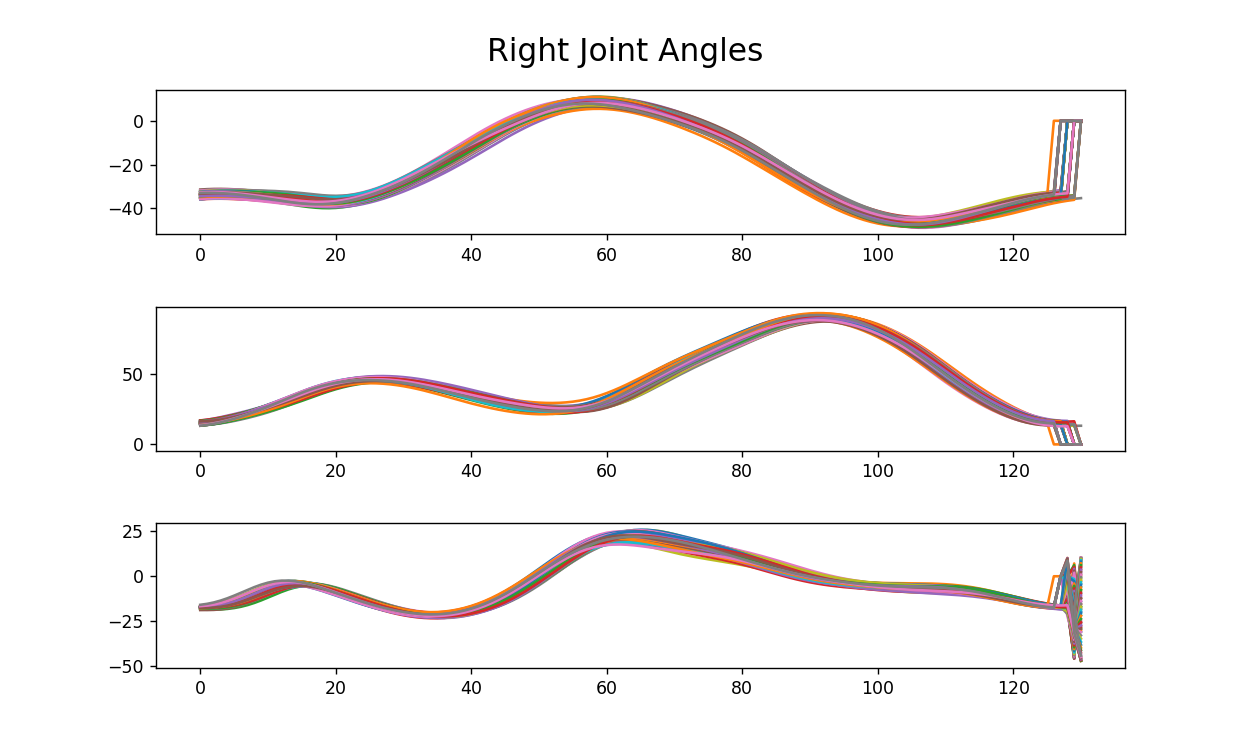

In [28]:
angs_R = np.empty(shape=(max_stride_time_R, len(joints), len(axes))) * np.NaN

fig, axs = plt.subplots(nrows=len(joints), ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Right Joint Angles", fontsize=18, y=0.95)
for j, joint in enumerate(joints):
    angs = np.array(data['out']['r_angles']['R_'+joint])
    ang = np.empty(shape=(max_stride_time_R, len(events)-1))
    for i in range(len(events)-1):
        x = angs[events[i][2]:events[i+1][2], 2]
        ang[0:x.shape[0],i] = x
    axs[j].plot(ang)
plt.show()

### Plot curves

<IPython.core.display.Javascript object>


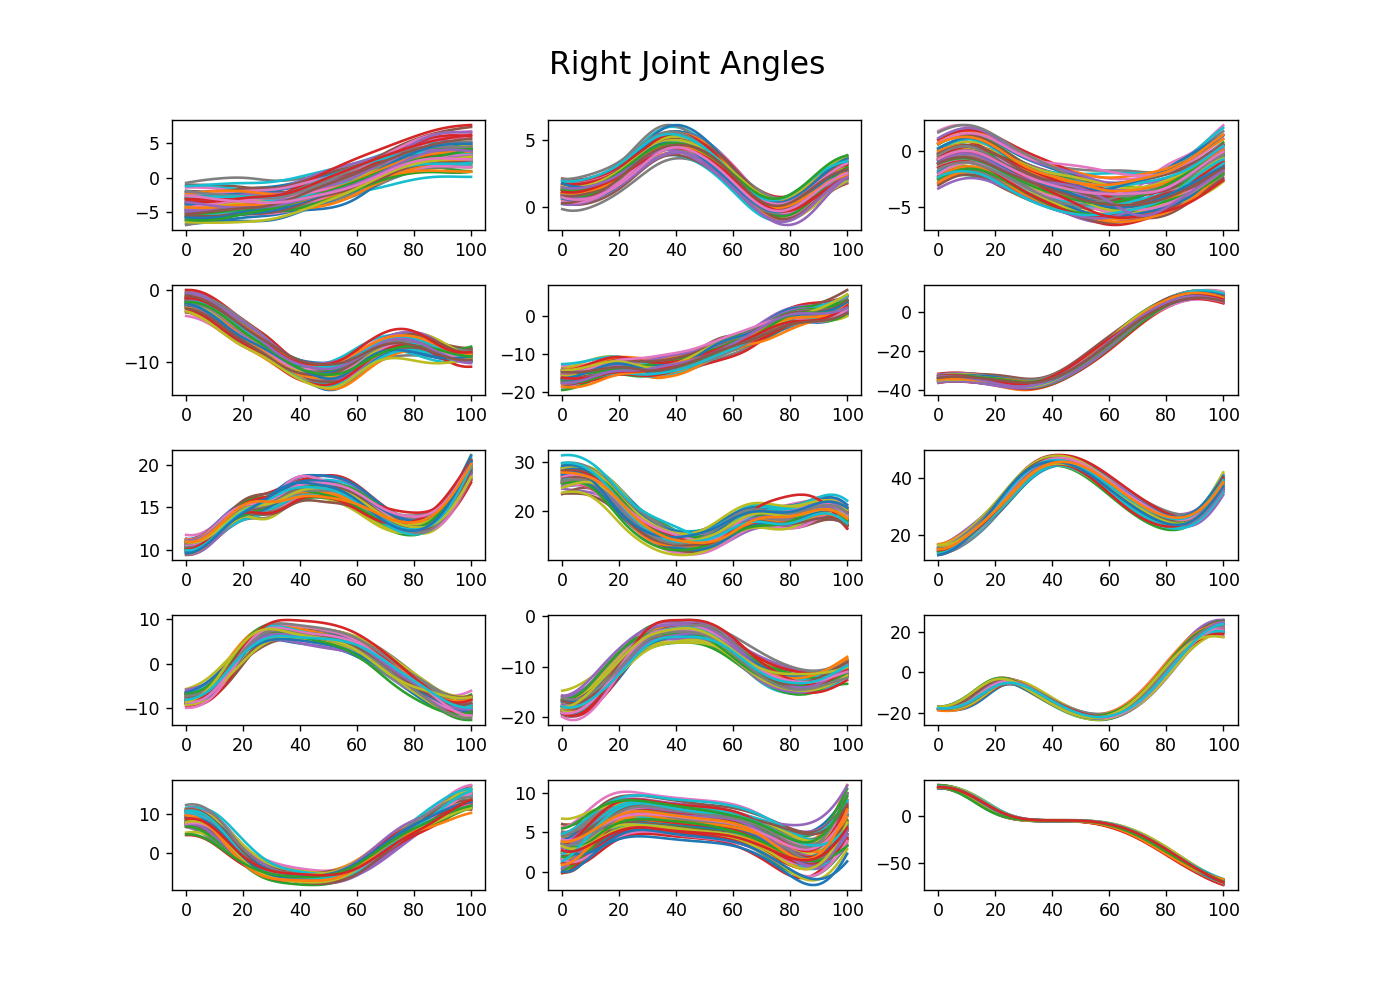

In [13]:
fig, axs = plt.subplots(nrows=len(joints), ncols=3, figsize=(11, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Right Joint Angles", fontsize=18, y=0.95)
for j, joint in enumerate(joints):
    angs = np.array(data['out']['r_norm_ang']['R_'+joint])
    for xyz, ax in enumerate(axes):
        
        axs[j,xyz].plot(angs[:,:,xyz])
plt.show()

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Right Joint Angles", fontsize=18, y=0.95)
axs[0,0].plot(angs_trials[:, 0, 0, 0,:])
axs[0,0].set_title(str(speed[0]/10)+' m/s')
axs[0,1].plot(angs_trials[:, 0, 0, 1,:])
axs[0,2].plot(angs_trials[:, 0, 0, 2,:])
plt.show()

(89, 4)

In [6]:
# Marker labels
mkr_labels_R = list(data['out']['full_run'].keys())

In [7]:
nframes = np.array(data['out']['full_run']['RPSI']).shape[0]
npoints = len(mkr_labels_R)

In [8]:
mkr_R_data = np.empty(shape=(4, npoints, nframes)) * np.NaN
mkr_R_data.shape

(4, 29, 12000)

In [9]:
mkr_R_data = np.empty(shape=(4, npoints, nframes))*np.NaN
for m, marker in enumerate(mkr_labels_R):
    mkr_R_data[0:3, m, :] = np.array(data['out']['full_run'][marker]).T

In [10]:
# Add a row of 1s to address c3d files requirements
mkr_R_data[3,:,:] = 1

## Import C3D RBDS file using EZC3D
https://github.com/pyomeca/ezc3d

In [11]:
import ezc3d

In [12]:
# Load an empty c3d structure
c3d = ezc3d.c3d()
# Fill it with random data
c3d['parameters']['POINT']['RATE']['value']   = [data['out']['hz_r']]
c3d['parameters']['POINT']['LABELS']['value'] = tuple(data['out']['full_run'].keys())
c3d['data']['points'] = mkr_R_data

In [14]:
# Write the data
fname_c3d = os.path.join(dir_path, '20130731T140334_run.c3d')
c3d.write(fname_c3d)

In [13]:
fname

'C:\\Users\\Reginaldo\\Documents\\data\\CNPq\\RIC\\20130731T140334.mat'

In [ ]:
# Load an empty c3d structure
c3d = ezc3d.c3d()

# Fill it with random data
c3d['parameters']['POINT']['RATE']['value'] = [100]
c3d['parameters']['POINT']['LABELS']['value'] = ('point1', 'point2', 'point3', 'point4', 'point5')
c3d['data']['points'] = np.random.rand(4, 5, 100)
c3d['data']['points'][1, :, :] = 2
c3d['data']['points'][2, :, :] = 3

c3d['parameters']['ANALOG']['RATE']['value'] = [1000]
c3d['parameters']['ANALOG']['LABELS']['value'] = ('analog1', 'analog2', 'analog3', 'analog4', 'analog5', 'analog6')
c3d['data']['analogs'] = np.random.rand(1, 6, 1000)
c3d['data']['analogs'][0, 0, :] = 4
c3d['data']['analogs'][0, 1, :] = 5
c3d['data']['analogs'][0, 2, :] = 6
c3d['data']['analogs'][0, 3, :] = 7
c3d['data']['analogs'][0, 4, :] = 8
c3d['data']['analogs'][0, 5, :] = 9

# Add a custom parameter to the POINT group
c3d.add_parameter("POINT", "newParam", [1, 2, 3])

# Add a custom parameter a new group
c3d.add_parameter("NewGroup", "newParam", ["MyParam1", "MyParam2"])

# Write the data
c3d.write("path_to_c3d.c3d")

### Create pandas df from dictionay
#### STATIC

In [ ]:
mkr_S_labels = list(data['out']['full_static'].keys())

In [ ]:
mkr_S_data = np.empty(shape=(200,3*len(mkr_S_labels)))
for m, marker in enumerate(mkr_S_labels):
    mkr_S_data[:,3*m:3*m+3] = np.array(data['out']['full_static'][marker])

In [ ]:
xyz = list('XYZ')*len(mkr_S_labels)
mkr_S_labels_2 = [ele for ele in mkr_S_labels for i in range(3)]
mkr_S_labels_3 = [mkr_S_labels_2[i]+'_'+xyz[i] for i in range(len(xyz))]

In [ ]:
df_S = pd.DataFrame(data=mkr_S_data, columns=mkr_S_labels_3)

In [ ]:
duration  = data['out']['hz_r']/mkr_S_data.shape[0]
timeStamps= np.linspace(0, duration, mkr_S_data.shape[0])

In [ ]:
df_S['Time'] = timeStamps
df_S.set_index('Time', inplace=True)
df_S.index.name = 'Time'

In [ ]:
df_S.head()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_S.values[100,2::3]
xdata = df_S.values[100,0::3]
ydata = df_S.values[100,1::3]
ax.scatter3D(xdata, ydata, zdata, c='b');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
plt.show()

## Markers rotation to be consistent with RBDS

In [ ]:
# Applying rotation matrix
df_Sm = df_S

In [ ]:
rot = np.array([[0,1,0],[0,0,1],[1,0,0]]) # rotate markers 90 deg
for m in range(len(mkr_S_labels)):
    for i in range(df_S.values.shape[0]):
        df_Sm.values[i,3*m:3*m+3] = rot @ df_S.values[i,3*m:3*m+3]

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_S.values[100,2::3]
xdata = df_S.values[100,0::3]
ydata = df_S.values[100,1::3]
ax.scatter3D(xdata, ydata, zdata, c='b');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
plt.show()

### Create pandas df from dictionay
#### RUNNING

In [ ]:
mkr_R_labels = list(data['out']['full_run'].keys())

In [ ]:
mkr_R_data = np.empty(shape=(12000,3*len(mkr_R_labels)))
for m, marker in enumerate(mkr_R_labels):
    mkr_R_data[:,3*m:3*m+3] = np.array(data['out']['full_run'][marker])

In [ ]:
xyz = list('XYZ')*len(mkr_R_labels)
mkr_R_labels_2 = [ele for ele in mkr_R_labels for i in range(3)]
mkr_R_labels_3 = [mkr_R_labels_2[i]+'_'+xyz[i] for i in range(len(xyz))]

In [ ]:
df_R_RIC = pd.DataFrame(data=mkr_R_data, columns=mkr_R_labels_3)

In [ ]:
duration  = mkr_R_data.shape[0]/data['out']['hz_r']
timeStamps_R= np.linspace(0, duration, mkr_R_data.shape[0])
df_R_RIC['Time'] = timeStamps_R
df_R_RIC.set_index('Time', inplace=True)
df_R_RIC.index.name = 'Time'

In [ ]:
df_R_RIC.head()

## Markers rotation to be consistent with RBDS

In [ ]:
# Applying rotation matrix
df_R_RICm = df_R_RIC

In [ ]:
rot = np.array([[0,1,0],[0,0,1],[1,0,0]]) # rotate markers 90 deg
for m in range(len(mkr_R_labels)):
    for i in range(df_R_RIC.values.shape[0]):
        df_R_RICm.values[i,3*m:3*m+3] = rot @ df_R_RIC.values[i,3*m:3*m+3]

## Gait events (TD and TO)
These gait events were detected in another NB (RIC_RBDS_gait_events_detection.ipynb) using the method of Zeni.

In [ ]:
iTD = np.array([  37,  143,  248,  352,  456,  559,  666,  772,  876,  982, 1089,
       1193, 1298, 1399, 1504, 1610, 1717, 1821, 1930, 2033, 2139, 2245,
       2351, 2456, 2563, 2668, 2775, 2877, 2985, 3088, 3195, 3298, 3404,
       3506, 3612, 3716, 3824, 3929, 4033, 4140, 4246, 4348, 4456],
      dtype=np.int64)

In [ ]:
iTO = np.array([  85,  192,  298,  402,  507,  610,  717,  819,  900, 1032, 1135,
       1241, 1346, 1449, 1556, 1659, 1766, 1871, 1978, 2081, 2187, 2293,
       2399, 2505, 2611, 2717, 2823, 2927, 3032, 3139, 3242, 3345, 3453,
       3558, 3661, 3767, 3872, 3977, 4057, 4189, 4293, 4397], dtype=np.int64)

## Plot static markers RIC

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_S.values[100,2::3]
xdata = df_S.values[100,0::3]
ydata = df_S.values[100,1::3]
ax.scatter3D(xdata, ydata, zdata, c='b');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
plt.show()

## Import C3D RBDS file using EZC3D
https://github.com/pyomeca/ezc3d

In [ ]:
from ezc3d import c3d

### Create pandas df
#### RUNNING

In [ ]:
fname_c3d_R = os.path.join(pathname,'RBDS001runT35.c3d')
c_R = c3d(fname_c3d_R)

In [ ]:
point_data_R = c_R['data']['points']
points_residuals_R = c_R['data']['meta_points']['residuals']
analog_data_R = c_R['data']['analogs']

### Rename marker labels to be consistent with RIC

In [ ]:
mkr_R_labels_RBDS = c_R['parameters']['POINT']['LABELS']['value']

In [ ]:
print(mkr_R_labels_RBDS)

In [ ]:
mkr_R_labels_RBDSm=['LASI', 'LHED', 'LHEL', 'LHEP', 'LIC', 'LMH1', 'LMH5', 
                    'LPSI', 'LSBL', 'LSBM', 'LSTL', 'LSTM', 
                    'LTBL', 'LTBM', 'LTTL', 'LTTM', 'RASI', 
                    'RHED', 'RHEL', 'RHEP', 'RIC', 'RMH1', 'RMH5', 'RPSI', 
                    'RSBL', 'RSBM', 'RSTL', 'RSTM', 
                    'RTBL', 'RTBM', 'RTTL', 'RTTM']

In [ ]:
mkr_R_data_RBDS = np.empty(shape=(point_data_R.shape[2],3*len(mkr_R_labels_RBDSm)))
for m, marker in enumerate(mkr_R_labels_RBDSm):
    mkr_R_data_RBDS[:,3*m:3*m+3] = point_data_R[:3, m, :].T

In [ ]:
xyz = list('XYZ')*len(mkr_R_labels_RBDSm)
mkr_R_labels_RBDS_2 = [ele for ele in mkr_R_labels_RBDSm for i in range(3)]
mkr_R_labels_RBDS_3 = [mkr_R_labels_RBDS_2[i]+'_'+xyz[i] for i in range(len(xyz))]

In [ ]:
df_R_RBDS = pd.DataFrame(data=mkr_R_data_RBDS, columns=mkr_R_labels_RBDS_3)

In [ ]:
duration_R  = point_data_R.shape[2]/int(c_R['parameters']['POINT']['RATE']['value'][0])
timeStamps_R= np.linspace(0, duration_R, mkr_R_data_RBDS.shape[0])

In [ ]:
df_R_RBDS['Time'] = timeStamps_R
df_R_RBDS.set_index('Time', inplace=True)
df_R_RBDS.index.name = 'Time'

In [ ]:
df_R_RBDS.head()

### STATIC

In [ ]:
fname_c3d = os.path.join(pathname,'RBDS001static.c3d')
c = c3d(fname_c3d)

In [ ]:
point_data = c['data']['points']
points_residuals = c['data']['meta_points']['residuals']
analog_data = c['data']['analogs']

In [ ]:
mkr_S_labels_RBDS = c['parameters']['POINT']['LABELS']['value']
print(mkr_S_labels_RBDS)

In [ ]:
mkr_S_labels_RBDSm=['LMAL', 'LMAM', 'LASI', 'LGTR', 'LHED', 'LHEL', 'LHEP', 
                    'LFIB', 'LIC', 'LKNL', 'LKNM', 'LMH1', 'LTOE', 'LMH5', 'LPSI', 'LSBL', 
                    'LSBM', 'LSTL', 'LSTM', 'LTBL', 'LTBM', 
                    'LTTL', 'LTTM', 'LTUB', 'RMAL', 'RMAM', 'RASI', 'RGTR', 'RHED', 
                    'RHEL', 'RHEP', 'RFIB', 'RIC', 'RKNL', 'RKNM', 'RMH1', 'RTOE', 'RMH5', 'RPSI', 
                    'RSBL', 'RSBM', 'RSTL', 'RSTM', 'RTBL', 
                    'RTBM', 'RTTL', 'RTTM', 'RTUB']

In [ ]:
mkr_S_data_RBDS = np.empty(shape=(point_data.shape[2],3*len(mkr_S_labels_RBDSm)))
for m, marker in enumerate(mkr_S_labels_RBDSm):
    mkr_S_data_RBDS[:,3*m:3*m+3] = point_data[:3, m, :].T

In [ ]:
xyz = list('XYZ')*len(mkr_S_labels_RBDSm)
mkr_S_labels_RBDS_2 = [ele for ele in mkr_S_labels_RBDSm for i in range(3)]
mkr_S_labels_RBDS_3 = [mkr_S_labels_RBDS_2[i]+'_'+xyz[i] for i in range(len(xyz))]

In [ ]:
df_S_RBDS = pd.DataFrame(data=mkr_S_data_RBDS, columns=mkr_S_labels_RBDS_3)

In [ ]:
duration  = int(c['parameters']['POINT']['RATE']['value'][0])/point_data.shape[2]
timeStamps= np.linspace(0, duration, mkr_S_data_RBDS.shape[0])

In [ ]:
df_S_RBDS['Time'] = timeStamps
df_S_RBDS.set_index('Time', inplace=True)
df_S_RBDS.index.name = 'Time'

In [ ]:
df_S_RBDS.head()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_S.values[100,2::3]
xdata = df_S.values[100,0::3]
ydata = df_S.values[100,1::3]
ax.scatter3D(xdata, ydata, zdata, c='b');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_S_RBDS.values[100,2::3]
xdata = df_S_RBDS.values[100,0::3]
ydata = df_S_RBDS.values[100,1::3]
ax.scatter3D(xdata, ydata, zdata, c='r');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
plt.show()

### Save df to ascii
RBDS and RIC

# Static
fname_out_RBDS = os.path.join(pathname, 'RBDS_static.csv')
df_S_RBDS.to_csv(fname_out_RBDS)
# Running
fname_out_R_RBDS = os.path.join(pathname, 'RBDS_run.csv')
df_R_RBDS.to_csv(fname_out_R_RBDS)

# Static
fname_out_RIC = os.path.join(pathname, 'RIC_static.csv')
df_Sm.to_csv(fname_out_RIC)
# Running
fname_out_R_RIC = os.path.join(pathname, 'RIC_run.csv')
df_R_RICm.to_csv(fname_out_R_RIC)

In [ ]:
fname_c3d_f = os.path.join(pathname,'RBDS001runT35.c3d')
c3d = c3d(fname_c3d_f, extract_forceplat_data=True);

pf_0 = c3d["data"]["platform"][0]  # Select the first platform

In [ ]:
pf_0['unit_force']          # Units of forces
pf_0['unit_moment']         # Units of moments
pf_0['unit_position']       # Units of center of pressure

pf_0['cal_matrix']          # Calibration matrix
pf_0['corners']             # Position of the corners
pf_0['origin']              # Position of the origin

pf_0['force']               # Force data
pf_0['moment']              # Moment data
pf_0['center_of_pressure']  # Center of pressure data
pf_0['Tz']                  # Moment at center of pressure data

In [ ]:
pf_0['cal_matrix'] 

In [ ]:
    if df_multi:  # dataframe with multiple labels
        df.drop(labels='Frame#', axis=1, inplace=True)
        df.set_index('Time', inplace=True)
        df.index.name = 'Time'
        cols = [s[:-1] for s in df.columns.str.replace(r'.', r'_')]
        df.columns = [cols, list('XYZ')*int(df.shape[1]/3), xyz]
        df.columns.set_names(names=['Marker', 'Coordinate', 'XYZ'],
                             level=[0, 1, 2], inplace=True)

In [ ]:
mkr_S_data.shape

In [ ]:
df_s = pd.DataFrame.from_dict(data['out']['full_static'])
df_s.head()

In [ ]:
data['out']['full_static']

In [ ]:
print(data['out'].keys())

In [ ]:
data['out']['neutral'].keys()

In [ ]:
data['out']['full_static'].keys()

In [ ]:
data['out'][0][0]

In [ ]:
data['__header__']

### Data stored in RBA directory

In [ ]:
fname_q= os.path.join(pathname, 'RBDS_google_forms.csv') 
# Import data
data_q = pd.read_csv(fname_q, sep = ',', index_col = 'ID')
data_q.head()

In [ ]:
df_rba = data_q[['Altura (cm)','Massa (kg)']]
df_rba

In [ ]:
df_figshare = info[['Subject','Height','Mass']]
df_figshare.set_index('Subject')

In [ ]:
df_out = df_rba.loc[df_rba['Altura (cm)']==df_figshare['Height'].values[5]]
df_out.index.tolist()

In [ ]:
ids = []
for i in range(df_figshare.shape[0]):
    df_out = df_rba.loc[(df_rba['Altura (cm)']==df_figshare['Height'].values[i]) & (df_rba['Massa (kg)']==df_figshare['Mass'].values[i])]
    if df_out.empty:
        print('Subject '+ str(df_figshare['Subject'].values[i]) + ' not found!')
    else:
        ids.append(df_out.index.tolist())

In [ ]:
ids

# PENDING
* Find who is who. 
Find the subjects in Figshare RBDSinfo.txt with the corresponding ID in RBA spreadsheet